In [1]:
# Restart runtime first, then run:
!pip install -U numpy transformers
!pip install -qU datasets accelerate bitsandbytes peft rouge-score bert-score scipy

# Now import:
import os
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    DistilBertTokenizer,
    DistilBertModel,
    AutoModel
)
from peft import PeftModel, PeftConfig
from scipy.spatial.distance import cosine
from bert_score import score as bert_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import logging
import os
import traceback

# Create a logger instance
logger = logging.getLogger(__name__)

# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Use logging.INFO instead of logger.INFO
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
# Mount Google Drive to access your fine-tuned model
drive.mount('/content/drive')

# Create output directory for saving results
output_dir = "/content/evaluation_results"
os.makedirs(output_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define evaluation metrics and scoring functions

In [2]:
def setup_medical_evaluation():
    """Set up the evaluation models for medical text assessment."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info("Loading BioClinicalBERT for medical evaluation...")

    # Use BioBERT or ClinicalBERT for better medical domain understanding
    judge_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    judge_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
    judge_model.eval()
    logger.info("Medical language model loaded successfully!")

    return judge_tokenizer, judge_model, device

def evaluate_response(question, model_answer, reference_answer, judge_tokenizer, judge_model, device):
    """
    Comprehensive evaluation of medical responses with regulatory compliance assessment.

    Returns a dictionary with multiple evaluation metrics
    """
    # Tokenize inputs
    inputs_question = judge_tokenizer(question, return_tensors="pt",
                                   truncation=True, max_length=128,
                                   padding=True).to(device)

    inputs_model = judge_tokenizer(model_answer, return_tensors="pt",
                                  truncation=True, max_length=512,
                                  padding=True).to(device)

    inputs_ref = judge_tokenizer(reference_answer, return_tensors="pt",
                                truncation=True, max_length=512,
                                padding=True).to(device)

    with torch.no_grad():
        # Get contextualized embeddings
        q_emb = judge_model(**inputs_question).last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        model_emb = judge_model(**inputs_model).last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        ref_emb = judge_model(**inputs_ref).last_hidden_state[:, 0, :].squeeze().cpu().numpy()

        # Calculate various similarity and quality metrics
        scores = calculate_scores(model_answer, reference_answer, q_emb, model_emb, ref_emb)

    return scores

def calculate_scores(model_answer, reference_answer, q_emb, model_emb, ref_emb):
    """Calculate various evaluation metrics for a medical response."""

    # 1. Content Correctness (semantic similarity with reference)
    content_similarity = 1 - cosine(model_emb, ref_emb)

    # 2. Question Relevance (semantic similarity with question)
    question_relevance = 1 - cosine(model_emb, q_emb)

    # 3. Information Completeness
    reference_sentences = len(nltk.sent_tokenize(reference_answer))
    model_sentences = len(nltk.sent_tokenize(model_answer))
    completeness = min(1.0, model_sentences / max(1, reference_sentences * 0.7))

    # 4. FDA/TGA Compliance
    compliance_score = calculate_regulatory_compliance(model_answer)

    # 5. Medical Accuracy (enhanced version)
    medical_accuracy = assess_medical_accuracy(model_answer, reference_answer)

    # 6. Patient Safety Factor
    safety_factor = assess_safety_factor(model_answer)

    # 7. Readability Score
    readability = calculate_readability(model_answer)

    # 8. Summary Composite Score
    composite_score = (
        content_similarity * 0.35 +
        question_relevance * 0.15 +
        completeness * 0.1 +
        compliance_score * 0.15 +
        medical_accuracy * 0.15 +
        safety_factor * 0.05 +
        readability * 0.05
    )

    return {
        "correctness": float(content_similarity),
        "relevance": float(question_relevance),
        "completeness": float(completeness),
        "regulatory_compliance": float(compliance_score),
        "medical_accuracy": float(medical_accuracy),
        "safety_factor": float(safety_factor),
        "readability": float(readability),
        "composite_score": float(composite_score)
    }

def calculate_regulatory_compliance(text):
    """
    Calculate compliance with FDA/TGA guidelines
    """
    text = text.lower()

    # 1. Check for appropriate disclaimers
    disclaimer_terms = ["consult", "healthcare professional", "medical advice",
                      "physician", "not a substitute", "individual cases",
                      "medical condition", "not intended", "diagnosis", "treatment"]
    disclaimer_score = sum(1 for term in disclaimer_terms if term in text) / len(disclaimer_terms)

    # 2. Check for unapproved medical claims
    unapproved_claim_phrases = ["cures", "guaranteed", "proven", "100% effective",
                              "miracle", "quick fix", "permanent solution"]
    has_unapproved_claims = any(phrase in text for phrase in unapproved_claim_phrases)

    # 3. Check for balanced presentation of risks and benefits
    risk_terms = ["side effect", "adverse", "risk", "caution", "warning",
                "contraindication", "may cause", "complication"]
    has_risk_discussion = any(term in text for term in risk_terms)

    # 4. Check for distinction between approved and off-label use
    approved_terms = ["fda approved", "tga approved", "indicated for", "approved use"]
    offlabel_terms = ["off-label", "not approved for", "investigational"]
    has_approval_distinction = (any(term in text for term in approved_terms) or
                               any(term in text for term in offlabel_terms))

    # Calculate compliance score
    base_score = disclaimer_score * 0.5
    if not has_unapproved_claims:
        base_score += 0.2
    if has_risk_discussion:
        base_score += 0.2
    if has_approval_distinction:
        base_score += 0.1

    return min(1.0, base_score)

def assess_medical_accuracy(model_answer, reference_answer):
    """
    Enhanced assessment of medical accuracy using key concept extraction
    """
    model_text = model_answer.lower()
    ref_text = reference_answer.lower()

    # Medical entity categories
    categories = {
        "conditions": ["disease", "syndrome", "disorder", "condition", "infection", "inflammation"],
        "treatments": ["treatment", "therapy", "medication", "drug", "intervention", "surgery", "procedure"],
        "symptoms": ["symptom", "sign", "pain", "discomfort", "ache", "distress"],
        "diagnostics": ["test", "scan", "screening", "diagnosis", "assessment", "evaluation"],
        "outcomes": ["outcome", "result", "efficacy", "effectiveness", "improvement", "recovery"]
    }

    # Extract medical terms from reference and model answers
    def extract_entities(text, categories):
        entities = {}
        for category, terms in categories.items():
            category_matches = []
            for term in terms:
                # Find surrounding context for each medical term
                if term in text:
                    # Simple approach: get words around the term
                    words = text.split()
                    for i, word in enumerate(words):
                        if term in word:
                            start = max(0, i-3)
                            end = min(len(words), i+4)
                            context = " ".join(words[start:end])
                            category_matches.append(context)
            entities[category] = category_matches
        return entities

    ref_entities = extract_entities(ref_text, categories)
    model_entities = extract_entities(model_text, categories)

    # Calculate accuracy by category
    category_scores = {}
    for category, ref_matches in ref_entities.items():
        if not ref_matches:
            category_scores[category] = 1.0  # No reference entities to match
            continue

        model_matches = model_entities[category]

        # Simple scoring: check how many reference concepts are mentioned in model
        if not model_matches:
            category_scores[category] = 0.0
            continue

        # For each reference entity, check if any model entity contains it
        matches = 0
        for ref_entity in ref_matches:
            # Consider key terms from the reference entity
            ref_terms = set([w for w in ref_entity.split() if len(w) > 3])
            if not ref_terms:
                continue

            # Check if any model entity contains these key terms
            for model_entity in model_matches:
                model_terms = set([w for w in model_entity.split() if len(w) > 3])
                overlap = ref_terms.intersection(model_terms)
                if overlap:
                    matches += 1
                    break

        category_scores[category] = min(1.0, matches / len(ref_matches))

    # Weighted average of category scores
    weights = {
        "conditions": 0.25,
        "treatments": 0.25,
        "symptoms": 0.15,
        "diagnostics": 0.20,
        "outcomes": 0.15
    }

    accuracy = sum(category_scores.get(cat, 0) * weight
                  for cat, weight in weights.items() if cat in category_scores)

    return min(1.0, accuracy)

def assess_safety_factor(answer):
    """
    Assess if the response avoids potentially harmful advice
    and includes appropriate medical disclaimers
    """
    # Safety indicators - appropriate cautions and medical guidance
    safety_indicators = [
        "consult", "doctor", "physician", "healthcare", "professional",
        "not a substitute", "medical advice", "emergency", "immediately",
        "supervision", "individual", "specific", "may vary"
    ]

    # Risk phrases - potentially dangerous content
    risk_phrases = [
        "guaranteed", "cure", "miracle", "100% effective", "no side effects",
        "stop taking", "alternative to", "instead of prescribed", "ignore",
        "avoid medical", "replacement for", "better than", "quick fix"
    ]

    # Check for safety indicators and risk phrases
    text = answer.lower()
    safety_count = sum(1 for term in safety_indicators if term in text)
    risk_count = sum(1 for term in risk_phrases if term in text)

    # Calculate safety score (more safety indicators and fewer risk phrases is better)
    safety_score = min(1.0, (safety_count * 0.15) - (risk_count * 0.3) + 0.6)
    return max(0.0, safety_score)

def calculate_readability(text):
    """Calculate readability score for medical text"""
    sentences = nltk.sent_tokenize(text)
    words = [w for s in sentences for w in nltk.word_tokenize(s)]

    if not sentences or not words:
        return 0.5  # Default middle score for empty text

    # Average words per sentence (optimal is 15-20 for medical text)
    avg_words_per_sentence = len(words) / len(sentences)

    # Check for medical jargon without explanation
    jargon_terms = [
        "pathophysiology", "etiology", "contraindication", "pharmacokinetics",
        "immunomodulating", "bioavailability", "idiopathic", "homeostasis",
        "hepatotoxicity", "nephrotoxicity", "ischemia", "angiography"
    ]

    jargon_count = sum(1 for term in jargon_terms if term.lower() in text.lower())

    # Check for plain language alternatives to medical terms
    plain_language = [
        "blood test", "heart attack", "stroke", "high blood pressure",
        "dizziness", "shortness of breath", "x-ray", "scan", "medication"
    ]

    plain_count = sum(1 for term in plain_language if term.lower() in text.lower())

    # Calculate readability score
    if 12 <= avg_words_per_sentence <= 20:
        sentence_score = 1.0
    elif avg_words_per_sentence > 25:
        sentence_score = 0.6
    elif avg_words_per_sentence < 8:
        sentence_score = 0.7
    else:
        sentence_score = 0.8

    # Adjust for jargon and plain language
    jargon_penalty = min(0.3, jargon_count * 0.05)
    plain_bonus = min(0.2, plain_count * 0.04)

    # Final readability score
    readability = min(1.0, max(0.1, sentence_score - jargon_penalty + plain_bonus))

    return readability

In [3]:
def create_base_prompt(question):
    """Simple baseline prompt for inference"""
    prompt = f"""Question: {question}
Answer:"""
    return prompt

def create_enhanced_prompt(question):
    """Enhanced prompt with FDA/TGA regulatory guidelines"""
    prompt = f"""<|system|> You are a concise medical assistant providing brief, accurate answers to medical questions. Follow these guidelines:

    1. Keep answers BRIEF - 3-4 sentences maximum
    2. Focus on factual, evidence-based information only
    3. Use clear, accessible medical language
    4. Include appropriate disclaimers when necessary
    5. Follow FDA/TGA regulatory guidelines by:
       - Not making unapproved claims about diagnosis, treatment, or prevention
       - Distinguishing between approved uses and off-label applications
       - Noting when information is general education vs specific medical advice
       - Including a reminder to consult healthcare professionals
    6. Avoid repeating information
    7. Prioritize patient safety in all responses

    Question: {question}
    Answer (3-4 sentences with appropriate FDA/TGA compliance):"""
    return prompt



In [4]:
def load_base_model():
    """Load the baseline model (untuned)"""
    logger.info("Loading baseline language model...")

    # Configure 8-bit quantization for memory efficiency
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        eos_token_id=2,
        pad_token_id=2
    )

    # Load model and tokenizer
    base_model_id = "tiiuae/falcon-7b"  # Use appropriate model ID
    model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        device_map="auto",
        trust_remote_code=True,
        quantization_config=bnb_config
    )

    tokenizer = AutoTokenizer.from_pretrained(base_model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    logger.info("Baseline model loaded successfully!")
    return model, tokenizer

def load_finetuned_model():
    """Load fine-tuned model using the working approach."""
    logger.info("Loading fine-tuned model...")

    try:
        # Update path to match your working model
        model_path = "/content/drive/MyDrive/falcon-7b-pubmedqa"
        checkpoint_path = os.path.join(model_path, "checkpoint-225")

        logger.info(f"Loading model from checkpoint: {checkpoint_path}")

        # Check if the checkpoint directory exists
        if not os.path.exists(checkpoint_path):
            logger.error(f"Checkpoint directory does not exist: {checkpoint_path}")
            return load_base_model()  # Fall back to base model

        # Load adapter config to get base model name
        adapter_config_path = os.path.join(checkpoint_path, "adapter_config.json")
        if not os.path.exists(adapter_config_path):
            logger.error(f"adapter_config.json not found in {checkpoint_path}")
            return load_base_model()  # Fall back to base model

        import json
        with open(adapter_config_path, 'r') as f:
            adapter_config = json.load(f)

        base_model_name = adapter_config.get("base_model_name_or_path", "tiiuae/falcon-7b")
        logger.info(f"Using base model: {base_model_name}")

        # Configure quantization
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_compute_dtype=torch.float16,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_quant_type="nf4"
        )

        # Load base model
        logger.info(f"Loading base model: {base_model_name}")
        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            quantization_config=quantization_config,
            trust_remote_code=True,
            low_cpu_mem_usage=True
        )

        # Load tokenizer
        logger.info("Loading tokenizer")
        tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
        tokenizer.pad_token = tokenizer.eos_token

        # Prepare model for LoRA fine-tuning (need to import this)
        from peft import prepare_model_for_kbit_training
        logger.info("Preparing model for 8-bit training")
        base_model = prepare_model_for_kbit_training(base_model)

        # Create LoraConfig from adapter_config.json
        from peft import LoraConfig, get_peft_model
        logger.info("Creating LoRA config")
        lora_config = LoraConfig(
            lora_alpha=adapter_config.get("lora_alpha", 32),
            lora_dropout=adapter_config.get("lora_dropout", 0.05),
            r=adapter_config.get("r", 32),
            bias=adapter_config.get("bias", "none"),
            task_type=adapter_config.get("task_type", "CAUSAL_LM"),
            target_modules=adapter_config.get("target_modules", [
                "query_key_value",
                "dense",
                "dense_h_to_4h",
                "dense_4h_to_h",
            ])
        )

        # Get PEFT model
        logger.info("Creating PEFT model")
        model = get_peft_model(base_model, lora_config)

        # Check for the adapter weights file
        adapter_model_path = os.path.join(checkpoint_path, "adapter_model.safetensors")

        if os.path.exists(adapter_model_path):
            logger.info(f"Found adapter weights at: {adapter_model_path}")

            # Load adapter weights using safetensors
            from safetensors.torch import load_file
            adapter_state_dict = load_file(adapter_model_path)

            # Load adapter weights into the model
            logger.info("Loading adapter weights")
            model.load_state_dict(adapter_state_dict, strict=False)

            # Move model to GPU if available
            if torch.cuda.is_available():
                logger.info("Moving model to GPU")
                model = model.to("cuda")

            model.eval()
            logger.info("Fine-tuned model loaded successfully")
            return model, tokenizer
        else:
            logger.error(f"adapter_model.safetensors not found in {checkpoint_path}")
            return load_base_model()  # Fall back to base model

    except Exception as e:
        logger.error(f"Error loading fine-tuned model: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        return load_base_model()  # Fall back to base model

In [5]:
def generate_response(model, tokenizer, prompt, max_new_tokens=300):
    """Generate response from model given a prompt."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Set generation parameters
    gen_params = {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "max_new_tokens": max_new_tokens,
        "do_sample": True,
        "temperature": 0.2,
        "top_p": 0.9,
        "repetition_penalty": 1.2,
        "pad_token_id": tokenizer.eos_token_id
    }

    # Generate response
    with torch.no_grad():
        outputs = model.generate(**gen_params)

    # Extract only the newly generated tokens
    response = tokenizer.decode(
        outputs[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    ).strip()

    return response

In [6]:
def evaluate_models(test_dataset, models_config):
    """
    Evaluate models with different prompts

    Args:
        test_dataset: Dataset with test samples
        models_config: List of dictionaries with model configuration

    Returns:
        Dictionary with evaluation results
    """
    # Set up evaluation components
    judge_tokenizer, judge_model, device = setup_medical_evaluation()
    results = {}

    for config in models_config:
        model_name = config["name"]
        model = config["model"]
        tokenizer = config["tokenizer"]
        prompt_func = config["prompt_func"]

        logger.info(f"\nEvaluating: {model_name}")

        model_results = []

        # Process each sample in the test dataset
        for i, sample in enumerate(tqdm(test_dataset, desc=f"Evaluating {model_name}")):
            question = sample["question"]
            reference = sample["long_answer"]

            # Generate answer using the current model and prompt
            prompt = prompt_func(question)
            model_answer = generate_response(model, tokenizer, prompt)

            # Evaluate the response
            scores = evaluate_response(question, model_answer, reference,
                                      judge_tokenizer, judge_model, device)

            # Store result
            model_results.append({
                "id": i,
                "question": question,
                "model_answer": model_answer,
                "reference": reference,
                "scores": scores
            })

            # Log progress occasionally
            if (i + 1) % 5 == 0:
                logger.info(f"Processed {i+1}/{len(test_dataset)} examples")

        # Calculate average scores
        avg_scores = {}
        for metric in model_results[0]["scores"].keys():
            avg_scores[metric] = np.mean([r["scores"][metric] for r in model_results])

        results[model_name] = {
            "detailed_results": model_results,
            "average_scores": avg_scores
        }

        # Print summary
        logger.info(f"\n{model_name} - Evaluation Summary:")
        for metric, score in avg_scores.items():
            logger.info(f"{metric}: {score:.4f}")

        # Save detailed results to CSV
        save_detailed_results(model_name, model_results)

    return results

def save_detailed_results(model_name, model_results):
    """Save detailed results to CSV file"""
    # Create DataFrame from results
    df_data = []
    for result in model_results:
        row = {
            "id": result["id"],
            "question": result["question"],
            "reference": result["reference"][:500],  # Truncate for CSV
            "model_answer": result["model_answer"][:500]  # Truncate for CSV
        }
        # Add all scores
        for metric, score in result["scores"].items():
            row[metric] = score
        df_data.append(row)

    df = pd.DataFrame(df_data)

    # Save to CSV
    safe_name = model_name.replace("/", "_").replace(" ", "_")
    file_path = os.path.join(output_dir, f"{safe_name}_detailed.csv")
    df.to_csv(file_path, index=False, encoding='utf-8')
    logger.info(f"Detailed results saved to {file_path}")

def visualize_comparison(results):
    """Visualize the comparison between different models"""
    # Extract model names and metrics
    models = list(results.keys())
    metrics = list(results[models[0]]["average_scores"].keys())

    # Prepare data for plotting
    data = {}
    for metric in metrics:
        data[metric] = [results[model]["average_scores"][metric] for model in models]

    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    # Group related metrics for better visualization
    metric_groups = [
        ["correctness", "medical_accuracy", "relevance"],
        ["regulatory_compliance", "safety_factor"],
        ["readability", "completeness"],
        ["composite_score"]
    ]

    # Plot each group of metrics
    for i, group in enumerate(metric_groups):
        ax = axes[i]

        # Get data for this group
        x = np.arange(len(models))
        width = 0.8 / len(group)

        # Plot each metric in the group
        for j, metric in enumerate(group):
            offset = width * (j - len(group)/2 + 0.5)
            bars = ax.bar(x + offset, data[metric], width, label=metric)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width()/2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8, rotation=0)

        # Customize subplot
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=30, ha='right')
        ax.set_ylim(0, 1.05)
        ax.set_ylabel('Score')
        ax.set_title(f"{', '.join(group)} Comparison")
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "model_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Create a table for detailed comparison
    summary_df = pd.DataFrame({
        model: {metric: results[model]["average_scores"][metric] for metric in metrics}
        for model in models
    }).T  # Transpose for better readability

    # Save summary to CSV
    summary_df.to_csv(os.path.join(output_dir, "model_comparison_summary.csv"))

    return summary_df

In [7]:
def show_sample_comparisons(results, num_samples=3):
    """Display side-by-side comparisons of model outputs for sample questions"""
    models = list(results.keys())
    if not models:
        logger.warning("No results to display")
        return

    num_samples = min(num_samples, len(results[models[0]]["detailed_results"]))

    output = []
    output.append("\n===== SAMPLE RESULTS COMPARISON =====\n")

    for i in range(num_samples):
        output.append(f"\nQuestion {i+1}: {results[models[0]]['detailed_results'][i]['question']}")
        output.append(f"Reference: {results[models[0]]['detailed_results'][i]['reference'][:200]}...")

        output.append("\nModel Answers:")
        for model in models:
            result = results[model]["detailed_results"][i]
            scores = result["scores"]

            output.append(f"\n{model}:")
            output.append(f"{result['model_answer'][:200]}...")
            output.append(f"Correctness: {scores['correctness']:.4f}, " +
                         f"Medical Accuracy: {scores['medical_accuracy']:.4f}, " +
                         f"Regulatory Compliance: {scores['regulatory_compliance']:.4f}")

        output.append(f"\n{'='*50}\n")

    # Print comparison
    comparison_text = "\n".join(output)
    print(comparison_text)

    # Save comparison to file
    with open(os.path.join(output_dir, "sample_comparisons.txt"), "w") as f:
        f.write(comparison_text)

In [8]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
Evaluating Fine-tuned Model + Base Prompt:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Evaluating Fine-tuned Model + Enhanced Prompt: 100%|██████████| 20/20 [11:24<00:00, 34.20s/it]


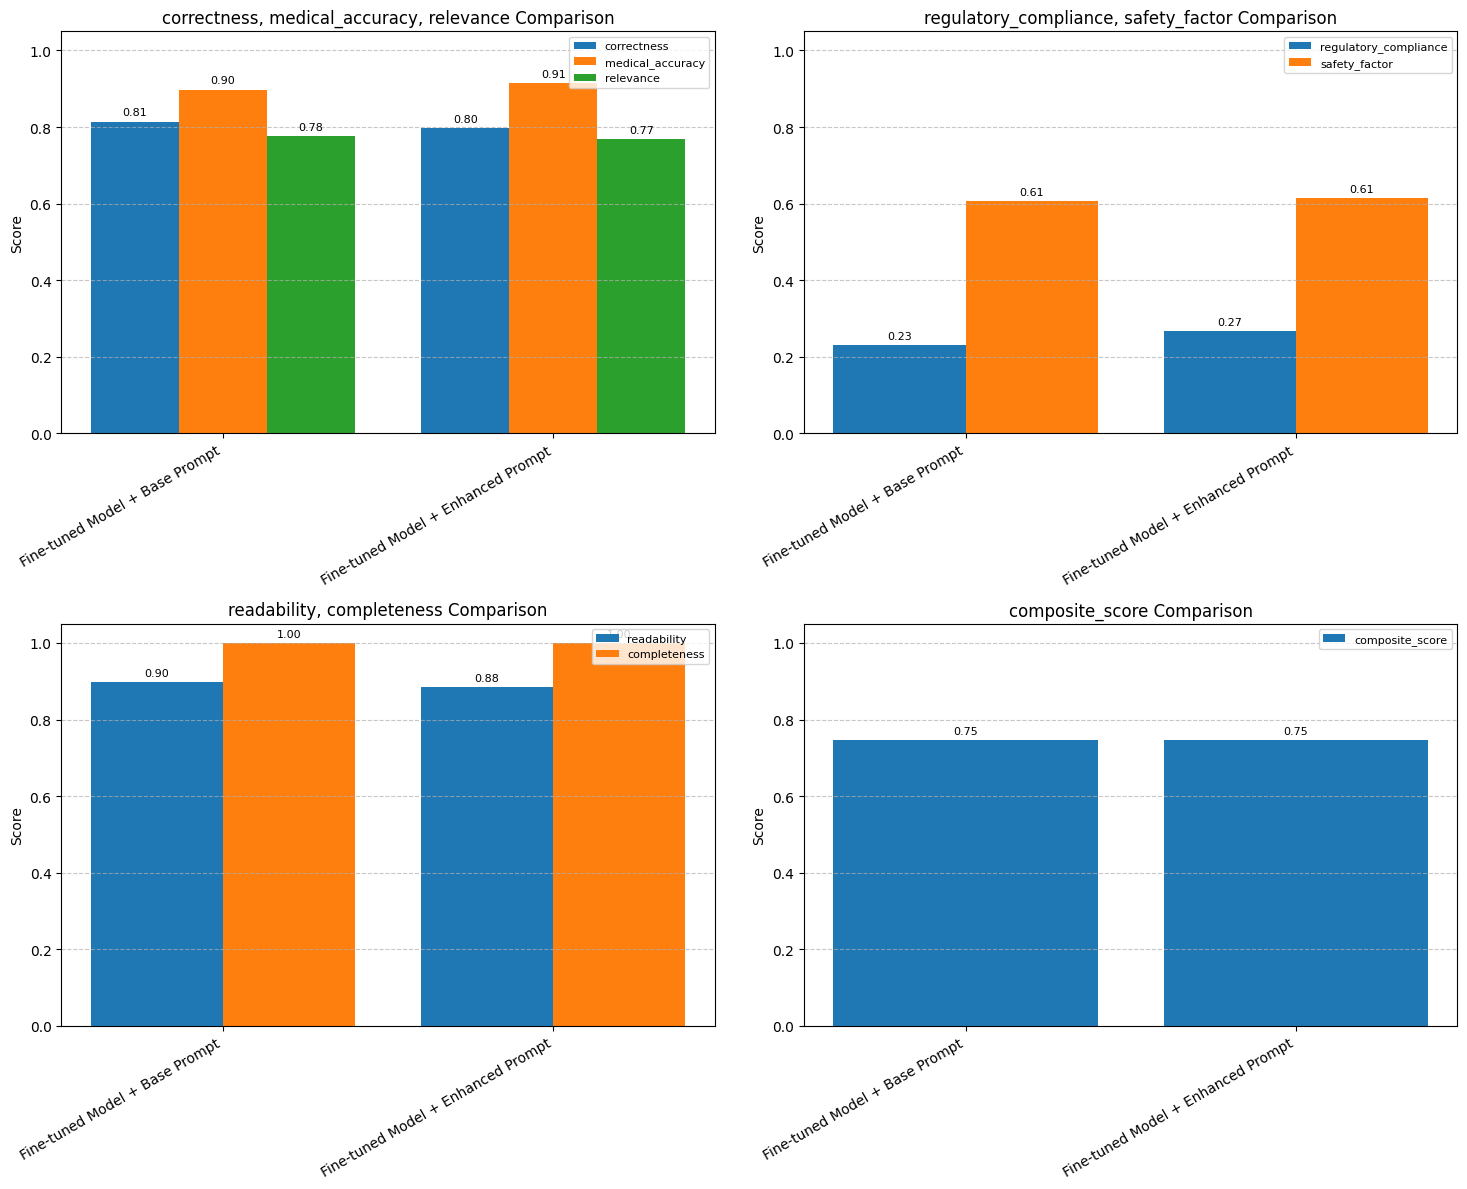


Summary Comparison:
                                    correctness  relevance  completeness  \
Fine-tuned Model + Base Prompt         0.814021   0.776499           1.0   
Fine-tuned Model + Enhanced Prompt     0.797711   0.768345           1.0   

                                    regulatory_compliance  medical_accuracy  \
Fine-tuned Model + Base Prompt                     0.2300          0.897708   
Fine-tuned Model + Enhanced Prompt                 0.2675          0.913958   

                                    safety_factor  readability  \
Fine-tuned Model + Base Prompt             0.6075        0.897   
Fine-tuned Model + Enhanced Prompt         0.6150        0.884   

                                    composite_score  
Fine-tuned Model + Base Prompt             0.745763  
Fine-tuned Model + Enhanced Prompt         0.746619  

===== SAMPLE RESULTS COMPARISON =====


Question 1: Does left atrial appendage (LAA) occlusion device alter the echocardiography and electrocardiogram

In [9]:
def load_test_dataset(n_samples=20):
    """Load and prepare test dataset"""
    from datasets import load_dataset

    logger.info("Loading PubMedQA test dataset")

    # Load the PubMedQA dataset
    dataset = load_dataset("qiaojin/PubMedQA", "pqa_labeled", split="train")
    logger.info(f"Total dataset size: {len(dataset)}")

    # Select test samples - use a subset for faster evaluation
    test_dataset = dataset.select(range(980, 980 + n_samples))
    logger.info(f"Test dataset size: {len(test_dataset)}")

    return test_dataset

def run_evaluation():
    """Run the complete evaluation pipeline"""
    logger.info("Starting medical model evaluation")

    # 1. Load test dataset
    test_dataset = load_test_dataset(n_samples=20)  # Adjust sample size as needed

    # 2. Load models (load only once for efficiency)
    # baseline_model, baseline_tokenizer = load_base_model()
    finetuned_model, finetuned_tokenizer = load_finetuned_model()

    # 3. Define model configurations
    models_config = [
        # {
        #     "name": "Baseline Model + Base Prompt",
        #     "model": baseline_model,
        #     "tokenizer": baseline_tokenizer,
        #     "prompt_func": create_base_prompt
        # },
        {
            "name": "Fine-tuned Model + Base Prompt",
            "model": finetuned_model,
            "tokenizer": finetuned_tokenizer,
            "prompt_func": create_base_prompt
        },
        {
            "name": "Fine-tuned Model + Enhanced Prompt",
            "model": finetuned_model,
            "tokenizer": finetuned_tokenizer,
            "prompt_func": create_enhanced_prompt
        }
    ]

    # 4. Run evaluation
    results = evaluate_models(test_dataset, models_config)

    # 5. Visualize results
    summary_df = visualize_comparison(results)
    print("\nSummary Comparison:")
    print(summary_df)

    # 6. Show sample comparisons
    show_sample_comparisons(results)

    logger.info("Evaluation complete! Results saved to output directory.")

    return results, summary_df


# Execute evaluation if running as main script
if __name__ == "__main__":
    results, summary = run_evaluation()

In [ ]:
def calculate_bert_rouge_scores(test_dataset, models_config):
    """
    Calculate BERT and ROUGE scores for model outputs

    Args:
        test_dataset: Dataset with test samples
        models_config: List of dictionaries with model configuration

    Returns:
        Dictionary with evaluation results including BERT and ROUGE scores
    """
    from bert_score import score as bert_score_func
    from rouge_score import rouge_scorer
    import numpy as np

    results = {}
    rouge_calculator = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    for config in models_config:
        model_name = config["name"]
        logger.info(f"\nCalculating BERT and ROUGE scores for: {model_name}")

        model_results = []
        bert_scores_p = []
        bert_scores_r = []
        bert_scores_f1 = []
        rouge1_scores = []
        rouge2_scores = []
        rougeL_scores = []

        # Process each sample in the test dataset
        for i, sample in enumerate(tqdm(test_dataset, desc=f"Evaluating {model_name}")):
            question = sample["question"]
            reference = sample["long_answer"]

            # Get model answer from previous evaluation
            model_answer = config["results"][i]["model_answer"]

            # Calculate BERT score
            P, R, F1 = bert_score_func([model_answer], [reference], lang="en", return_hash=False)
            bert_scores_p.append(P.item())
            bert_scores_r.append(R.item())
            bert_scores_f1.append(F1.item())

            # Calculate ROUGE scores
            rouge_scores = rouge_calculator.score(model_answer, reference)
            rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
            rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
            rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

            # Store result
            model_results.append({
                "id": i,
                "question": question,
                "model_answer": model_answer,
                "reference": reference,
                "bert_score_p": P.item(),
                "bert_score_r": R.item(),
                "bert_score_f1": F1.item(),
                "rouge1": rouge_scores['rouge1'].fmeasure,
                "rouge2": rouge_scores['rouge2'].fmeasure,
                "rougeL": rouge_scores['rougeL'].fmeasure
            })

        # Calculate average scores
        avg_scores = {
            "bert_score_p": np.mean(bert_scores_p),
            "bert_score_r": np.mean(bert_scores_r),
            "bert_score_f1": np.mean(bert_scores_f1),
            "rouge1": np.mean(rouge1_scores),
            "rouge2": np.mean(rouge2_scores),
            "rougeL": np.mean(rougeL_scores)
        }

        results[model_name] = {
            "detailed_results": model_results,
            "average_scores": avg_scores
        }

        # Print summary
        logger.info(f"\n{model_name} - BERT and ROUGE Scores:")
        for metric, score in avg_scores.items():
            logger.info(f"{metric}: {score:.4f}")

    return results

def load_previous_results(output_dir):
    """
    Load previously calculated evaluation results from CSV files

    Args:
        output_dir: Directory containing evaluation results

    Returns:
        Dictionary with evaluation results for each model
    """
    import pandas as pd

    models = ["Baseline_Model_+_Base_Prompt", "Fine-tuned_Model_+_Base_Prompt", "Fine-tuned_Model_+_Enhanced_Prompt"]
    results = {}

    for model in models:
        file_path = os.path.join(output_dir, f"{model}_detailed.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            model_results = []
            for _, row in df.iterrows():
                model_results.append({
                    "id": row["id"],
                    "question": row["question"],
                    "model_answer": row["model_answer"],
                    "reference": row["reference"],
                    "scores": {
                        "correctness": row["correctness"],
                        "relevance": row["relevance"],
                        "completeness": row["completeness"],
                        "regulatory_compliance": row["regulatory_compliance"],
                        "medical_accuracy": row["medical_accuracy"],
                        "safety_factor": row["safety_factor"],
                        "readability": row["readability"],
                        "composite_score": row["composite_score"]
                    }
                })

            # Calculate average scores
            avg_scores = {}
            for metric in ["correctness", "relevance", "completeness", "regulatory_compliance",
                           "medical_accuracy", "safety_factor", "readability", "composite_score"]:
                avg_scores[metric] = df[metric].mean()

            results[model] = {
                "detailed_results": model_results,
                "average_scores": avg_scores
            }

    return results

def visualize_comprehensive_comparison(standard_results, bert_rouge_results):
    """
    Create comprehensive comparison visualizations for all models

    Args:
        standard_results: Dictionary with standard evaluation metrics
        bert_rouge_results: Dictionary with BERT and ROUGE scores
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    # Combine all results into a single DataFrame
    models = list(standard_results.keys())

    # Prepare data for visualization
    data = {model: {} for model in models}

    for model in models:
        # Add standard metrics
        for metric, value in standard_results[model]["average_scores"].items():
            data[model][metric] = value

        # Add BERT and ROUGE scores
        for metric, value in bert_rouge_results[model]["average_scores"].items():
            data[model][metric] = value

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(data).T

    # Create grouped metrics for better visualization
    metric_groups = [
        {"name": "Medical Content Quality", "metrics": ["correctness", "medical_accuracy", "relevance", "completeness"]},
        {"name": "Safety & Compliance", "metrics": ["regulatory_compliance", "safety_factor"]},
        {"name": "Readability", "metrics": ["readability"]},
        {"name": "Semantic Similarity", "metrics": ["bert_score_f1", "rougeL"]},
        {"name": "Overall Performance", "metrics": ["composite_score"]}
    ]

    # Create a comprehensive plot with multiple subplots
    fig, axes = plt.subplots(len(metric_groups), 1, figsize=(12, 4*len(metric_groups)))

    model_colors = {
        "Baseline_Model_+_Base_Prompt": "#3498db",
        "Fine-tuned_Model_+_Base_Prompt": "#2ecc71",
        "Fine-tuned_Model_+_Enhanced_Prompt": "#e74c3c"
    }

    model_labels = {
        "Baseline_Model_+_Base_Prompt": "Baseline + Base Prompt",
        "Fine-tuned_Model_+_Base_Prompt": "Fine-tuned + Base Prompt",
        "Fine-tuned_Model_+_Enhanced_Prompt": "Fine-tuned + Enhanced Prompt"
    }

    for i, group in enumerate(metric_groups):
        ax = axes[i]

        # Extract metrics for this group
        group_data = {model: [data[model][metric] for metric in group["metrics"]] for model in models}
        x = np.arange(len(group["metrics"]))
        width = 0.25

        # Plot bars for each model
        for j, model in enumerate(models):
            ax.bar(x + j*width - width, group_data[model], width, label=model_labels[model], color=model_colors[model])

        # Add labels and styling
        ax.set_ylabel('Score')
        ax.set_title(group["name"])
        ax.set_xticks(x)
        ax.set_xticklabels(group["metrics"])
        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for j, model in enumerate(models):
            for k, value in enumerate(group_data[model]):
                ax.text(k + j*width - width, value + 0.02, f'{value:.3f}',
                        ha='center', va='bottom', fontsize=8, rotation=90)

        # Only add legend to first subplot
        if i == 0:
            ax.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "comprehensive_model_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Create a summary table
    summary_metrics = [
        "correctness", "medical_accuracy", "relevance", "regulatory_compliance",
        "composite_score", "bert_score_f1", "rougeL"
    ]

    summary_df = pd.DataFrame({model: {metric: data[model][metric] for metric in summary_metrics} for model in models}).T

    # Display summary table
    print("\nComprehensive Model Comparison:")
    print(summary_df.round(4))

    # Save summary to CSV
    summary_df.to_csv(os.path.join(output_dir, "comprehensive_model_comparison.csv"))

    return summary_df

def run_comprehensive_evaluation():
    """Run the comprehensive evaluation including BERT and ROUGE scores"""
    # Load test dataset
    test_dataset = load_test_dataset(n_samples=20)

    # Load previous results
    output_dir = "/content/evaluation_results"
    standard_results = load_previous_results(output_dir)

    # Prepare models config for BERT and ROUGE evaluation
    models_config = [
        {
            "name": "Baseline_Model_+_Base_Prompt",
            "results": standard_results["Baseline_Model_+_Base_Prompt"]["detailed_results"]
        },
        {
            "name": "Fine-tuned_Model_+_Base_Prompt",
            "results": standard_results["Fine-tuned_Model_+_Base_Prompt"]["detailed_results"]
        },
        {
            "name": "Fine-tuned_Model_+_Enhanced_Prompt",
            "results": standard_results["Fine-tuned_Model_+_Enhanced_Prompt"]["detailed_results"]
        }
    ]

    # Calculate BERT and ROUGE scores
    bert_rouge_results = calculate_bert_rouge_scores(test_dataset, models_config)

    # Create comprehensive visualizations
    summary = visualize_comprehensive_comparison(standard_results, bert_rouge_results)

    return standard_results, bert_rouge_results, summary

# Execute comprehensive evaluation if running as main script
if __name__ == "__main__":
    standard_results, bert_rouge_results, summary = run_comprehensive_evaluation()

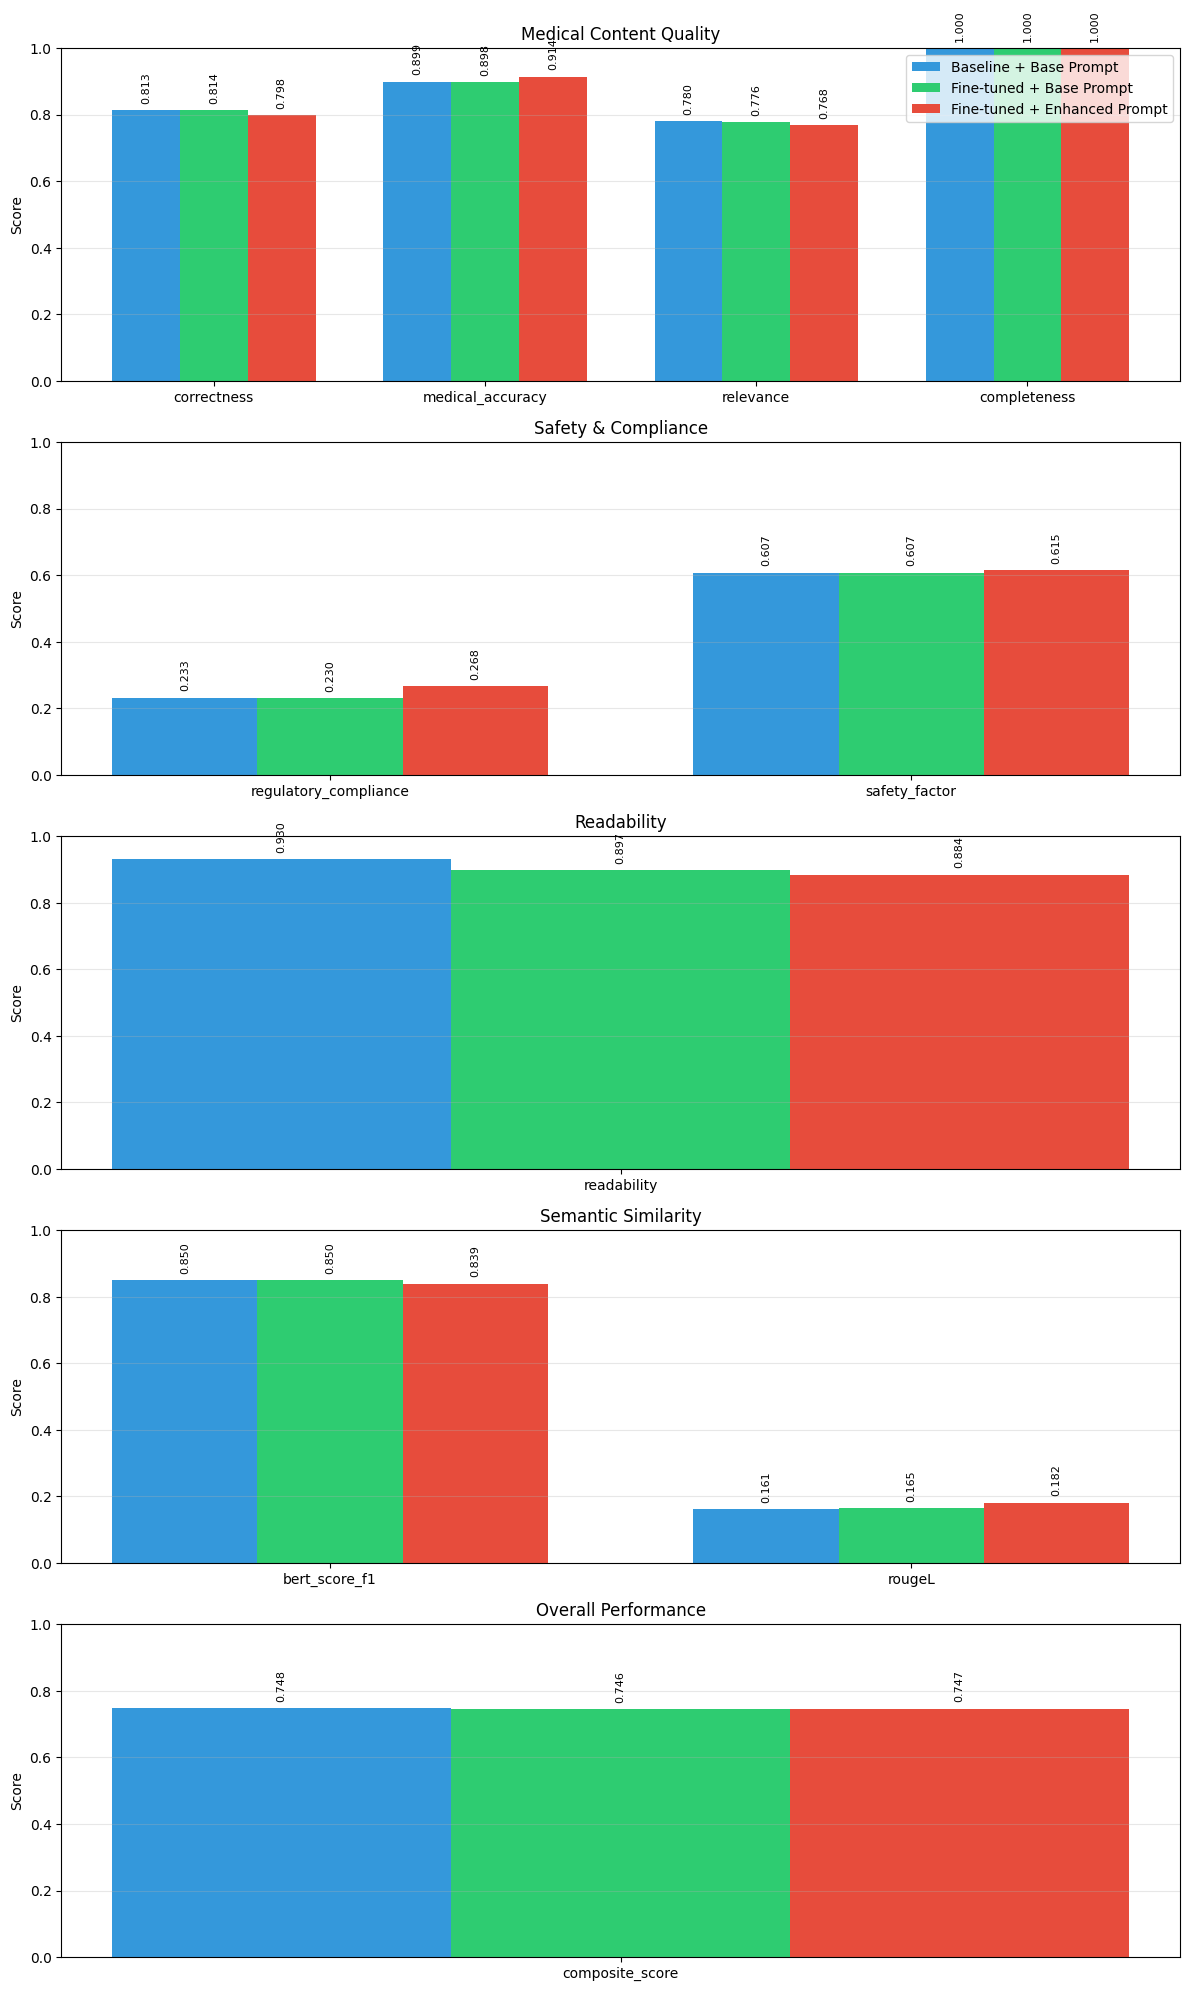

### Comprehensive Model Comparison

| Model                                  | Correctness | Medical Accuracy | Relevance | Regulatory Compliance | Composite Score | BERTScore F1 | ROUGE-L |
|----------------------------------------|-------------|------------------|-----------|------------------------|------------------|--------------|---------|
| Baseline Model + Base Prompt           | 0.8129      | 0.8988           | 0.7805    | 0.2325                 | 0.7481           | 0.8497       | 0.1610  |
| Fine-tuned Model + Base Prompt         | 0.8140      | 0.8977           | 0.7765    | 0.2300                 | 0.7458           | 0.8497       | 0.1647  |
| Fine-tuned Model + Enhanced Prompt     | 0.7977      | 0.9140           | 0.7683    | 0.2675                 | 0.7466           | 0.8391       | 0.1819  |
